The calculations of loss during the training of networks can use weighting to reinforce the learning of specific variables and features in data. In order to reinforce physically reasonable predictions, you can impose more strict penalties for predictions in physically invalid predictions. For example, a prediction of Power Conversion Efficiency (PCE) above the Schockley-Quassier predicted maximum PCE could increase exponentially, rather than linearly.

The classes developed below are wrappers for PyTorch tensors loss functions, which additionally modify these classes using theoretically and emprically derived boundaries for network loss calculations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
#Take in data as a dataframe for easy preprocessing
device_df = pd.read_excel('/Users/wesleytatum/Desktop/OPV_device_df.xlsx')
print (device_df.shape)
device_df.head()

# Hyper parameters
num_epochs = 100
batch_size = int(len(device_df['PCE'])*0.8*0.9) # 90% of x_train samples
learning_rate = 0.0008

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

X = device_df[['Time (min)', 'Temp (C)']] #input features used to make prediction
Y = device_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

pce_train = y_train['PCE']
pce_test = y_test['PCE']


x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
pce_train_tensor = torch.tensor(pce_train.values.astype(np.float32))


#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, pce_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
pce_test_tensor = torch.tensor(pce_test.values.astype(np.float32))


test_tensor = torch.utils.data.TensorDataset(x_test_tensor, pce_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

(366, 11)


In [10]:
#define the neural network
class NN1(nn.Module):
    
    def __init__(self, in_dims, out_dims):
        super(NN1, self).__init__()
        
        #emedding layer
        self.em_layer = nn.Linear(in_dims, out_dims)
        
        #hidden layers
        self.h_layer1 = nn.Linear(out_dims, 32)
        self.h_layer2 = nn.Linear(32, 16)
        self.h_layer3 = nn.Linear(16, 8)
        
        #output layers
        self.PCE_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        #data enters embedding layer
        out = self.em_layer(x)
        
        #embedded data is passed to hidden layers
        out = self.h_layer1(out)
        out = self.h_layer2(out)
        out = self.h_layer3(out)
        
        #embedded data is passed to output layer
        out = self.PCE_branch(out)
        
        return out

In [21]:
def train_model(model, training_data_set, criterion, optimizer):
    epoch_losses = []
    epoch_accuracies = []
    
    train_total = 0
    
    #switch model to training mode
    model.train()
    
    criterion = criterion
    
    for train_data, labels in training_data_set:
        
        train_data = train_data.to(device)
        labels = labels.to(device)
        
        model.zero_grad() #zero out any gradients from prior loops 
        out = model(train_data) #gather model predictions for this loop
        
        #calculate batch loss and accuracy in the predictions
        batch_loss, batch_accuracy = criterion(out, labels)

        #BACKPROPOGATE LIKE A MF
        batch_loss.backward
        optimizer.step()
        
        #save loss for this batch
        epoch_losses.append(batch_loss.item())
        epoch_accuracies.append(batch_accuracy)
        train_total+=1
        
    #calculate and save total error and accuracy for this epoch of training
    epoch_loss = sum(epoch_losses)/train_total
    epoch_accuracy = sum(epoch_accuracies)/train_total
    
    #update progress bar
    print(f'Epoch training loss: {epoch_loss}')
    print(f'Epoch training accuracy: {epoch_accuracy}')
    
    return epoch_loss, epoch_accuracy

In [30]:
def eval_model(model, testing_data_set, criterion, optimizer):
    #evaluate the model
    model.eval()
    
    criterion = criterion


    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
        
        epoch_losses = []
        epoch_accuracies = []
    
        test_total = 0

        for inputs, labels in testing_data_set:
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            out = model(inputs)

    
            # calculate loss per batch of testing data
            test_loss, test_accuracy = criterion(out, labels)
            
            epoch_losses.append(test_loss.item())
            epoch_accuracies.append(test_accuracy)
            test_total += 1 
            

        test_epoch_loss = sum(epoch_losses)/test_total
        test_epoch_accuracy = sum(epoch_accuracies)/test_total

        print(f"Epoch testing loss is: {test_epoch_loss}")
        print(f"Epoch testing accuracy is: {test_epoch_accuracy}")
    return test_epoch_loss, test_epoch_accuracy

In [31]:
class ThresholdedMSELoss(nn.Module):
    """
    This class contains loss functions that use a mean-squared-error loss for reasonable predictions.
    They inherit from torch.nn.Module just like the custom model. For physically unreasonable conditions,
    prediction loss is more severely calculated. What qualifies as reasonable is based on empirically
    gathered datasets and literature reported boundaries of performance.
    
    For the following predictions that are improbable, the loss is penalized:
    - X < lower
    - X > upper
    """

    def __init__(self, lower, upper):
        super(ThresholdedMSELoss, self).__init__()
        self.lower = lower
        self.upper = upper

    def forward(self, predictions, labels):
#         print (predictions.size())
#         print (labels.size())
        
        result_list = torch.zeros(predictions.size(0))
        element_count = 0
        correct = 0
        
        for x, y in zip(predictions, labels):
#             print (f"{el_count+1}/{result_list.size(0)}")
            
            # if (x >= 0) == 1 (True)
            if torch.le(x, torch.tensor([self.lower])) == torch.tensor([1]):
                #Exponential MSE for x <= 0
#                 print(f"prediction = {x}, lower threshold violated")

                # Need to use only torch.nn.Function() and torch.() functions for autograd to track operations
                error = torch.add(x, torch.neg(y)) #error = x + (-y)
        
                #if precision <= 10%, count as correct
                if torch.le(torch.div(error, y), torch.tensor(0.1)) == torch.tensor([1]):
                    correct += 1
            
                element_result = torch.pow(error, 2)
                element_result = torch.pow(element_result, 1)
            

           # if (x <= 6) == 1 (True)
            elif torch.ge(x, torch.tensor([self.upper])) == torch.tensor([1]):
                #exponential MSE for x >= 6
#                 print(f"prediction = {x}, upper threshold violated")
                error = torch.add(x, torch.neg(y))
            
            #if precision <= 10%, count as correct
                if torch.le(torch.div(error, y), torch.tensor(0.1)) == torch.tensor([1]):
                    correct += 1
            
                element_result = torch.pow(error, 2)
                element_result = torch.pow(element_result, 1)

                # all other values of x
            else:
#                 print(f"prediction = {x}")
                error = torch.add(x, torch.neg(y))
                
                #if precision <= 10%, count as correct
                if torch.le(torch.div(error, y), torch.tensor(0.1)) == torch.tensor([1]):
                    correct += 1
            
                element_result = torch.pow(error, 2)
                
            result_list[element_count] = element_result
            element_count+=1
            
            accuracy = correct/element_count

            result = result_list.mean()

            return result, accuracy


In [32]:
# Instantiate our beautiful NN model
# takes in 2 features (anneal time, anneal temp) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
model = NN1(in_dims = 2, out_dims = 4).to(device)

# define the loss function and the optimizer
criterion = ThresholdedMSELoss(lower = 0, upper = 6)
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [33]:
#empty list to hold loss per epoch
train_epoch_losses = []
train_epoch_accuracy = []


test_epoch_losses = []
test_epoch_accuracy = []


for epoch in range(num_epochs):
    
    train_epoch_loss, train_epoch_accuracy_element = train_model(model = model,
                                                                training_data_set = training_data_set,
                                                                criterion = criterion,
                                                                optimizer = optimizer)
    train_epoch_losses.append(train_epoch_loss)
    train_epoch_accuracy.append(train_epoch_accuracy_element)
    
    
    test_epoch_loss, test_epoch_accuracy_element = eval_model(model = model,
                                                              testing_data_set = testing_data_set,
                                                              criterion = criterion,
                                                              optimizer = optimizer)
    test_epoch_losses.append(test_epoch_loss)
    test_epoch_accuracy.append(test_epoch_accuracy_element)

Epoch training loss: 0.004420480108819902
Epoch training accuracy: 1.0
Epoch testing loss is: 0.0736137181520462
Epoch testing accuracy is: 1.0
Epoch training loss: 0.13532872777432203
Epoch training accuracy: 1.0
Epoch testing loss is: 0.02644318901002407
Epoch testing accuracy is: 1.0
Epoch training loss: 0.12884344439953566
Epoch training accuracy: 1.0
Epoch testing loss is: 0.004107087850570679
Epoch testing accuracy is: 1.0
Epoch training loss: 0.11416486682719551
Epoch training accuracy: 1.0
Epoch testing loss is: 0.006936823017895222
Epoch testing accuracy is: 1.0
Epoch training loss: 0.06501047313213348
Epoch training accuracy: 1.0
Epoch testing loss is: 0.06235610321164131
Epoch testing accuracy is: 1.0
Epoch training loss: 0.03837744798511267
Epoch training accuracy: 1.0
Epoch testing loss is: 0.030100319534540176
Epoch testing accuracy is: 1.0
Epoch training loss: 0.011399263516068459
Epoch training accuracy: 0.5
Epoch testing loss is: 0.06837689131498337
Epoch testing accur

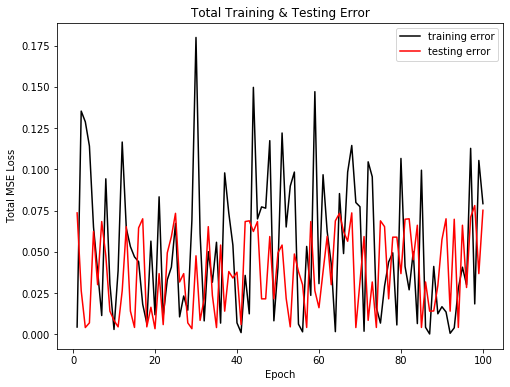

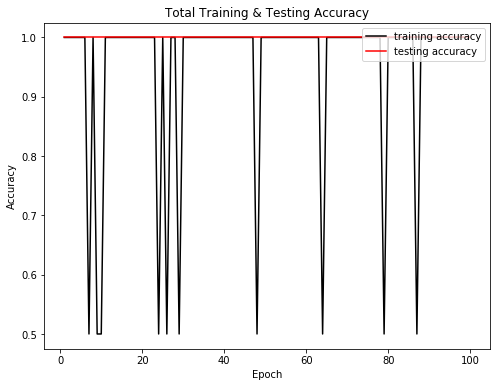

In [34]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total MSE Loss')
plt.show()

fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_accuracy, c = 'k', label = 'training accuracy')
plt.plot(epochs, test_epoch_accuracy, c = 'r', label = 'testing accuracy')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Accuracy")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.show()